**Import required packages for analysis**

In [1]:
import glob
import mne
import q1k_sync_tools as qst
import pylossless as ll
from mne.time_frequency import psd_array_welch
from matplotlib import pyplot as plt

In [2]:
from mne import Epochs, find_events
from mne.io import read_raw_eyelink

In [3]:
import numpy as np
import pandas as pd

**Read in the participant's data file**

In [4]:
eyelink_fname = '/Users/lina_01/Downloads/q1k_plr_ext_pilot_et/008_pr_1.asc'
raw = read_raw_eyelink(eyelink_fname, create_annotations=['blinks', 'messages'])

Loading /Users/lina_01/Downloads/q1k_plr_ext_pilot_et/008_pr_1.asc
Pixel coordinate data detected.Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area detected.
There are 4 recording blocks in this file. Times between  blocks will be annotated with BAD_ACQ_SKIP.


**Pre-process the file and divide into 'epochs' based on each flash trial**

In [5]:
mne.preprocessing.eyetracking.interpolate_blinks(raw)
raw.filter(l_freq=None, h_freq=5)

events = find_events(raw, 'DIN',
                     shortest_event=1,
                     min_duration=.02,
                     uint_cast=True)
event_dict = {'flash': events[0][2]}

epochs = Epochs(raw, events, tmin=0, tmax=2.5,
                event_id=event_dict, preload=True, baseline=None, reject_by_annotation=True)

epochs.pick('pupil_right')

Interpolating missing data during blinks...
Removing 'BAD_' from BAD_blink.
Filtering raw data in 4 contiguous segments
Setting up low-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 1651 samples (1.651 s)

32 events found
Event IDs: [6]
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped


/Users/lina_01/acar-q1k-pilot-seg/seg_env/lib/python3.11/site-packages/mne/event.py:503: RuntimeWarning: invalid value encountered in cast
  data = data.astype(np.int64)


Number of events,32
Events,flash: 32
Time range,0.000 – 2.500 s
Baseline,off


**Visualizing the epochs**

In [6]:
sizes = epochs.get_data().squeeze()
times = list(epochs.times)
sizes_df = pd.DataFrame(sizes, columns=times)

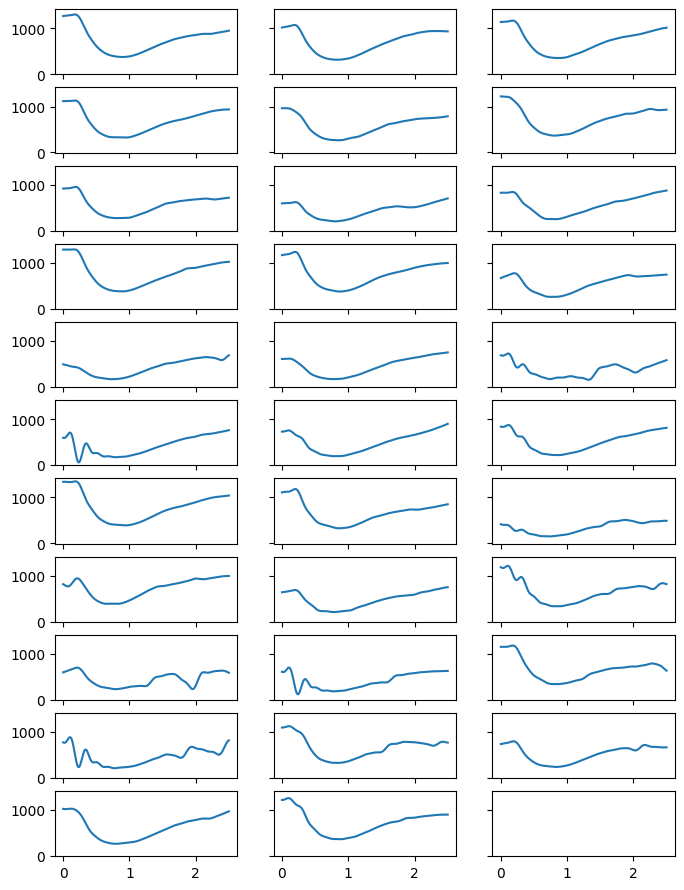

In [7]:
nrows = int(np.ceil(sizes_df.shape[0]/3))
fig, axes = plt.subplots(nrows,3,figsize=(8,nrows),sharex=True, sharey=True)
for ax,(ind,row) in zip(axes.ravel(),sizes_df.iterrows()):
    ax.plot(row)

**Calculating the acceleration of the pupil at each time-point between onset of flash and the lowest constriction point**

In [8]:
sizes = epochs.get_data().squeeze()
times = list(epochs.times)

sizes_df = pd.DataFrame(sizes, columns=times)

sizes_df_diff = sizes_df.diff(axis=1)
sizes_df_diff_velocities = sizes_df_diff/0.001
sizes_df_diff_acceleration = sizes_df_diff_velocities/0.001

**Finding the time-point associated with the lowest acceleration since onset of flash**

In [9]:
latencies = sizes_df_diff_acceleration.columns[sizes_df_diff_acceleration.apply(np.argmin, axis=1).values]
latencies

Index([0.306,  0.31, 0.309, 0.307, 0.351, 0.357,   0.3, 0.309,  0.28, 0.305,
       0.303, 0.317, 0.311,  0.36, 0.185, 0.175, 0.353, 0.192, 0.301, 0.299,
       0.166, 0.313, 0.304, 0.375,  0.32, 0.179, 0.298, 0.174, 0.374, 0.304,
       0.337, 0.354],
      dtype='float64')

**Visualizing each epoch with a line identifying the latency**

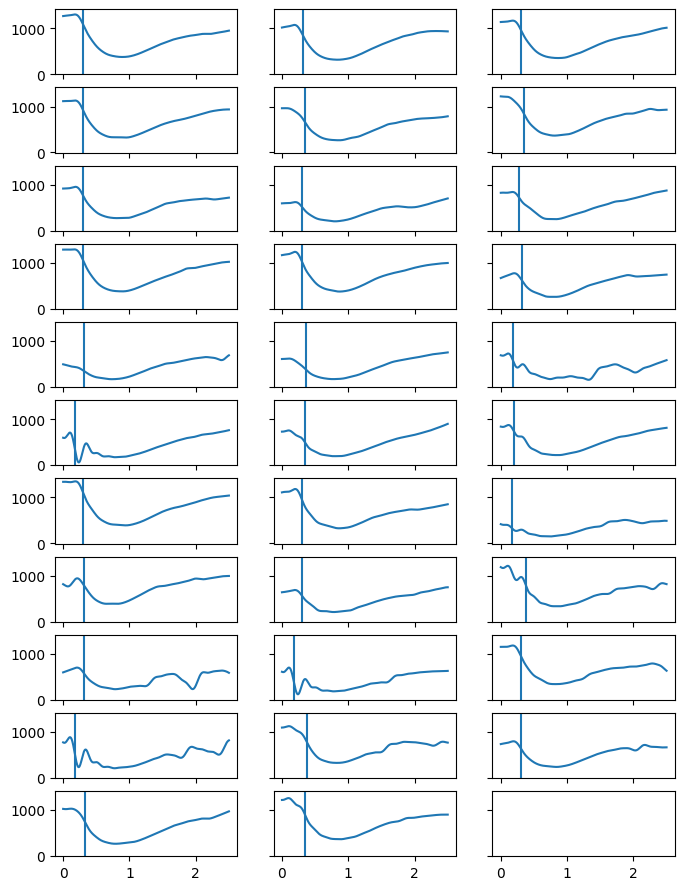

In [10]:
nrows = int(np.ceil(sizes_df.shape[0]/3))
fig, axes = plt.subplots(nrows,3,figsize=(8,nrows),sharex=True, sharey=True)
for ax,(ind,row),latency in zip(axes.ravel(),sizes_df.iterrows(),latencies):
    ax.plot(row)
    ax.axvline(x=latency)

**Calculating the average latency**

In [11]:
latencies.values.mean()

0.29609375